In [1]:
#importing all the required libraries

import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import pandas as pd
import geopandas as gpd
import mapclassify as mc
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline
from pyproj import Transformer, CRS, Proj
from shapely.geometry import shape, Point, Polygon
import numpy as np
import shapely.speedups as speedups
speedups.enable()

In [2]:
#defining output folder and reading the csv as geodataframe 

OUTPUT = Path.cwd().parents[0] / "Output"
df = pd.read_csv(Path.cwd().parents[0] /"CSV"/"HLL"/"latlng_to_geohash.csv")
gdf = gpd.GeoDataFrame(df,geometry =gpd.points_from_xy(df.longitude_3,df.latitude_3),crs ="EPSG:4326")
gdf

,latitude_3,longitude_3,usercount,postcount,hashtags,geometry
0,51.328125,-0.703125,1225,2219,muslimban,POINT (-0.70312 51.32812)
1,51.328125,-0.703125,1129,2135,refugees,POINT (-0.70312 51.32812)
2,51.328125,-0.703125,953,1974,refugeeswelcome,POINT (-0.70312 51.32812)
3,48.515625,2.109375,917,2831,migrants,POINT (2.10938 48.51562)
4,51.328125,-0.703125,883,1704,immigration,POINT (-0.70312 51.32812)
...,...,...,...,...,...,...
143243,41.484375,16.171875,1,1,essereumani,POINT (16.17188 41.48438)
143244,41.484375,16.171875,1,1,facciadiculo,POINT (16.17188 41.48438)
143245,41.484375,16.171875,1,1,facebook,POINT (16.17188 41.48438)
143246,41.484375,16.171875,1,1,falsita,POINT (16.17188 41.48438)


In [4]:
#reading the custom made shapefile to be used for the spatial join and other spatial operations

eu = gpd.read_file(Path.cwd().parents[0] / "Europe_coastline_shapefile"/ "eu_shp_4326.shp")
eu.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,142257519,Europe,Russia,RUS,3745000.0,"MULTIPOLYGON (((20.89224 54.31252, 19.66064 54..."
1,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((25.68921 69.09211, 24.73568 68..."
2,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((6.65823 49.20196, 8.09928 49.0..."
3,8299706,Asia,Israel,ISR,297000.0,"POLYGON ((34.92260 29.50133, 34.82324 29.76108..."
4,6229794,Asia,Lebanon,LBN,85160.0,"POLYGON ((35.12605 33.09090, 35.24322 33.35887..."


Text(0.5, 1.0, 'Geo-hashed points')

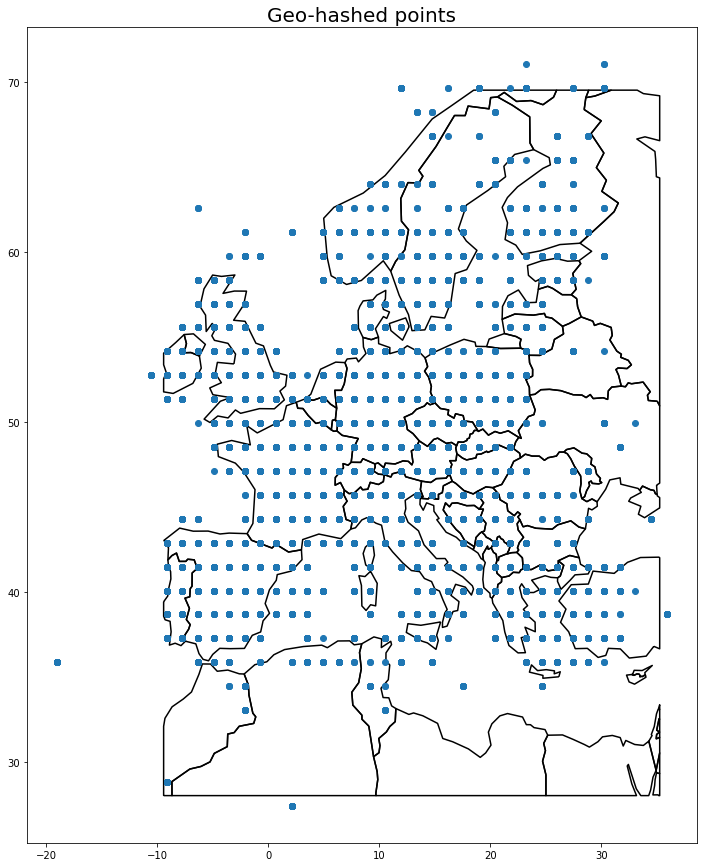

In [5]:
#plotting the geohashed points over the custom EU shapefile to check if everything is alright

fig,ax = plt.subplots(1,figsize=(15,15))
eu.boundary.plot(ax=ax,
                 edgecolor = 'black')
gdf.plot(ax=ax,
         zorder = 2)
plt.title("Geo-hashed points",size = 20)
#plt.savefig(OUTPUT / 'geohashed_points.jpeg',quality =95,bbox_inches = 'tight')

<AxesSubplot:title={'center':'FR'}>

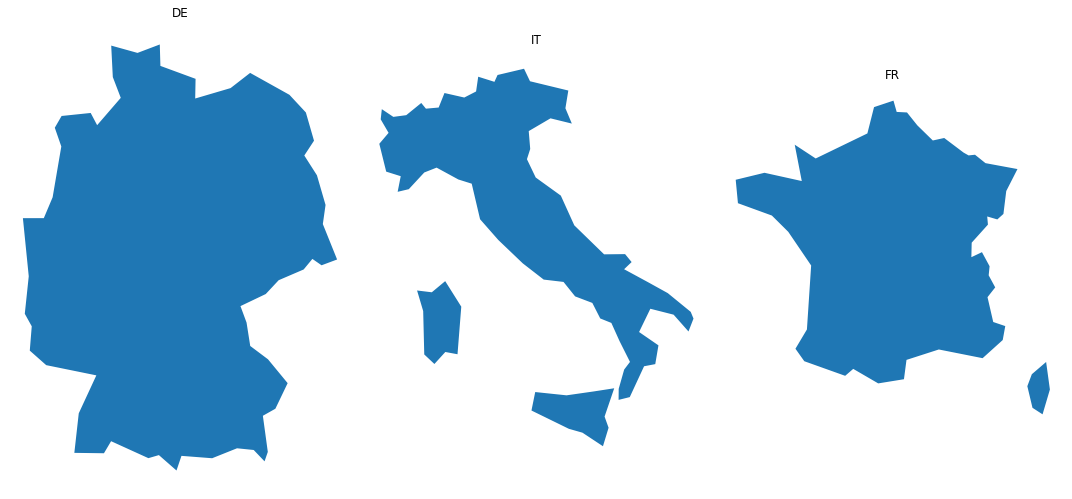

In [6]:
#extracting boundaries of countries for making specific country based grids 

de = eu[eu['name'] == "Germany"]
fr = eu[eu['name'] == "France"]
it = eu[eu['name'] == "Italy"]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,10))

for ax in (ax1,ax2,ax3):
    ax.set_axis_off()
    
plt.tight_layout()

ax1.title.set_text('DE')
ax2.title.set_text('IT')
ax3.title.set_text('FR')

de.plot(ax=ax1)
it.plot(ax=ax2)
fr.plot(ax=ax3)

In [7]:
#create grids for Germany

GRID_SIZE_METERS = 100000 
                        
# target projection: Web Mercator (epsg code)
EPSG_CODE = 3857
CRS_PROJ = f"epsg:{EPSG_CODE}"
# Input projection WGS 84
CRS_WGS = "epsg:4326"

# define Transformer ahead of time
# with xy-order of coordinates
PROJ_TRANSFORMER = Transformer.from_crs(
    CRS_WGS, CRS_PROJ, always_xy=True)

# also define reverse projection
PROJ_TRANSFORMER_BACK = Transformer.from_crs(
    CRS_PROJ, CRS_WGS, always_xy=True)

In [8]:
#co-ordinates for the edge points of Germany to be used for conversion

de.total_bounds

array([ 5.98865807, 47.3024877 , 15.01699588, 54.98310415])

In [9]:
(5.98865807+15.01699588)/2

10.502826975

In [10]:
#converting the points from WGS84 to Web Mercator

XMIN = PROJ_TRANSFORMER.transform(5.98865807, 10.502826975)[0]
XMAX = PROJ_TRANSFORMER.transform(15.01699588, 10.502826975)[0]
YMAX = PROJ_TRANSFORMER.transform(51.142795925, 54.98310415)[1]
YMIN = PROJ_TRANSFORMER.transform(51.142795925, 47.3024877)[1]


In [16]:
print(f'Projected bounds: {[XMIN, YMIN, XMAX, YMAX]}')

Projected bounds: [666654.3668874284, 5991588.288677101, 1671684.334606287, 7358587.663334562]


In [17]:
#creating the polygon grids

width = GRID_SIZE_METERS
length = GRID_SIZE_METERS
cols = list(range(int(np.floor(XMIN)), int(np.ceil(XMAX)), width))
rows = list(range(int(np.floor(YMIN)), int(np.ceil(YMAX)), length))
rows.reverse()

polygons = []
for x in cols:
     for y in rows:
            # combine to tuple: (x,y, poly)
            # and append to list
            polygons.append(
                (x, y,
                 Polygon([
                     (x, y),
                     (x+width, y),
                     (x+width, y-length),
                     (x, y-length)])))
grid = pd.DataFrame(polygons)
    # name columns
col_labels=['xbin', 'ybin', 'bin_poly']
grid.columns = col_labels
    # use x and y as index columns
grid.set_index(['xbin', 'ybin'], inplace=True)
grid.head()

bin_poly
xbin   ybin                                                      
666654 7291588  POLYGON ((666654 7291588, 766654 7291588, 7666...
       7191588  POLYGON ((666654 7191588, 766654 7191588, 7666...
       7091588  POLYGON ((666654 7091588, 766654 7091588, 7666...
       6991588  POLYGON ((666654 6991588, 766654 6991588, 7666...
       6891588  POLYGON ((666654 6891588, 766654 6891588, 7666...

In [18]:
#converting the grid from pandas dataframe to GeoPandas geodataframe
grid = gpd.GeoDataFrame(
        grid.drop(
            columns=["bin_poly"]),
            geometry=grid.bin_poly)
grid.crs = CRS_PROJ

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 14.5 µs


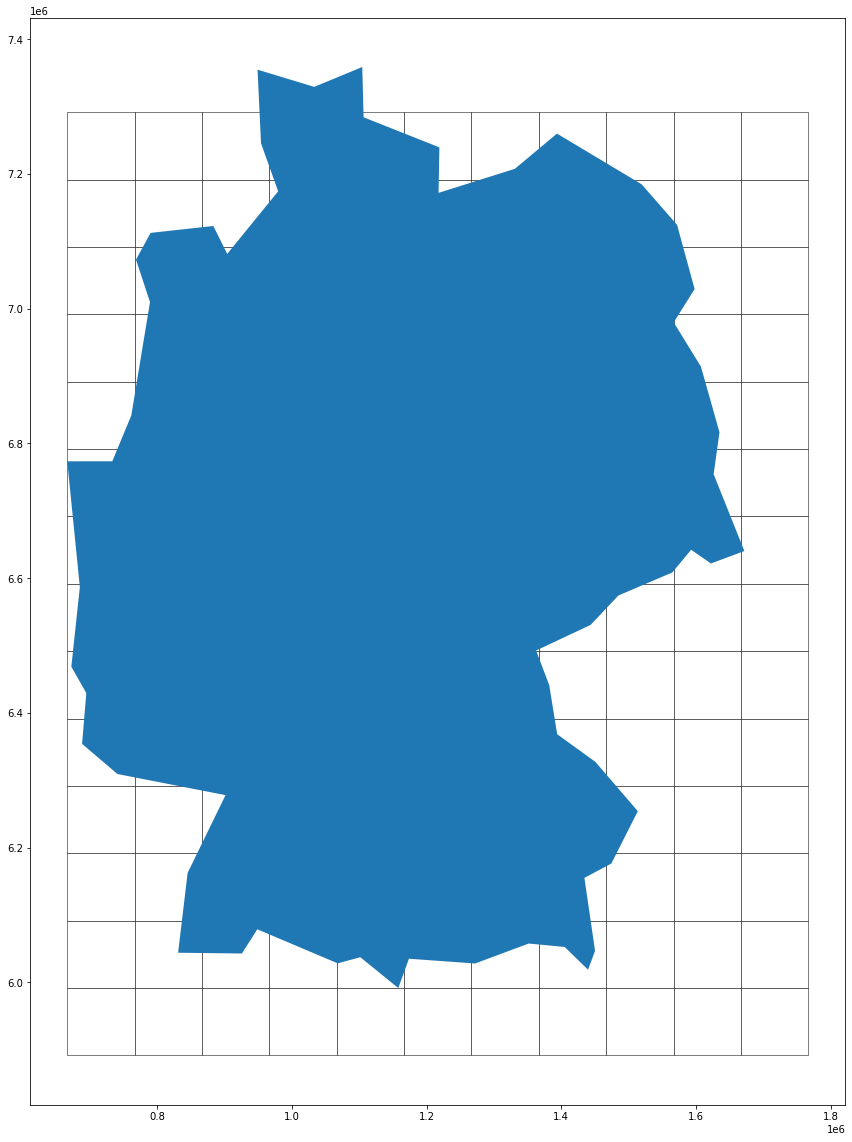

In [20]:
#grids created and the boundary of Germany, to check if things are alright

%time

base = grid.plot(figsize=(15,20), color='white', edgecolor='black', linewidth=0.5)
# combine with world geometry
plot = de.to_crs(epsg = 3857).plot(ax=base)

In [37]:
#using the centroid of the grids for the spatial join. The logic is use the grids whose centroids falls 
#wthin the boundary of Germany and delete the other grids. Here the grids are being identified.  

centroid_grid = grid.centroid.reset_index()
centroid_grid.set_index(["xbin", "ybin"], inplace=True)

centroid_grid = gpd.GeoDataFrame(
        grid.centroid)
centroid_grid.rename(
        columns={0:'geometry'},
        inplace=True)
centroid_grid.set_geometry(
        'geometry', crs=grid.crs, 
        inplace=True)
grid_intersect_de = gpd.sjoin(
        centroid_grid, de.to_crs(epsg = 3857), 
        how='right')

grid_intersect_de.set_index(
        ["index_left0", "index_left1"],
        inplace=True)
grid_intersect_de.index.names = ['xbin','ybin']
grid_de = grid.loc[grid_intersect_de.index]


In [12]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
#Here the useful grids are being kept with a spatial join for the final Germany grids

grid_join_de = gpd.sjoin(gdf.to_crs(epsg=3857),grid_de, how="right", op='within')
grid_join_de

index_left  latitude_3  longitude_3  usercount  postcount  \
xbin    ybin                                                                 
666654  6791588         NaN         NaN          NaN        NaN        NaN   
        6691588     83635.0   51.328125     6.328125        1.0        3.0   
        6691588     83384.0   51.328125     6.328125        1.0        1.0   
        6691588     83385.0   51.328125     6.328125        1.0        1.0   
        6691588     83386.0   51.328125     6.328125        1.0        1.0   
...                     ...         ...          ...        ...        ...   
1566654 6691588     87843.0   51.328125    14.765625        1.0        3.0   
        6691588     87865.0   51.328125    14.765625        1.0        2.0   
        6691588     87864.0   51.328125    14.765625        1.0        1.0   
        6691588     87863.0   51.328125    14.765625        1.0        1.0   
        6691588     87862.0   51.328125    14.765625        1.0        1.0   

                              hashtags  \
xbin    ybin                             
666654  6791588                    NaN   
        6691588          luilekkerland   
        6691588              inleiding   
        6691588         innenausschuss   
        6691588  innonazionaleitaliano   
...                                ...   
1566654 6691588                btw2017   
        6691588            istafberlin   
        6691588            immigration   
        6691588                   gysi   
        6691588              gutachten   

                                                          geometry  
xbin    ybin                                                        
666654  6791588  POLYGON ((666654.000 6791588.000, 766654.000 6...  
        6691588  POLYGON ((666654.000 6691588.000, 766654.000 6...  
        6691588  POLYGON ((666654.000 6691588.000, 766654.000 6...  
        6691588  POLYGON ((666654.000 6691588.000, 766654.000 6...  
        6691588  POLYGON ((666654.000 6691588.000, 766654.000 6...  
...                                                            ...  
1566654 6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  
        6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  
        6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  
        6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  
        6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  

[20798 rows x 7 columns]

(616654.0, 1716654.0, 5926588.0, 7356588.0)

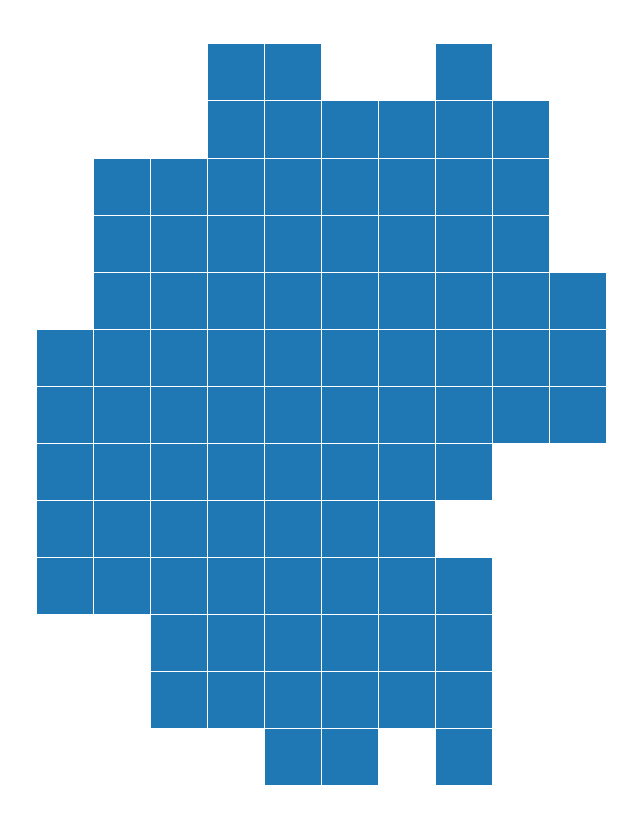

In [39]:
#take a look at the grid

fig,ax = plt.subplots(figsize = (20,15))
grid_join_de.plot(edgecolor= 'white',ax =ax)
plt.axis('off')


In [41]:
#we clean the geodataframe from NaN values

grid_join_de['postcount']=grid_join_de['postcount'].fillna(0) 
grid_join_de['usercount']=grid_join_de['usercount'].fillna(0) 

foo = grid_join_de.drop(columns = ['index_left', 'latitude_3', 'longitude_3','hashtags'])

foo.drop_duplicates(inplace =True)



Text(0.5, 1.0, 'postcount for every grid in Germany')

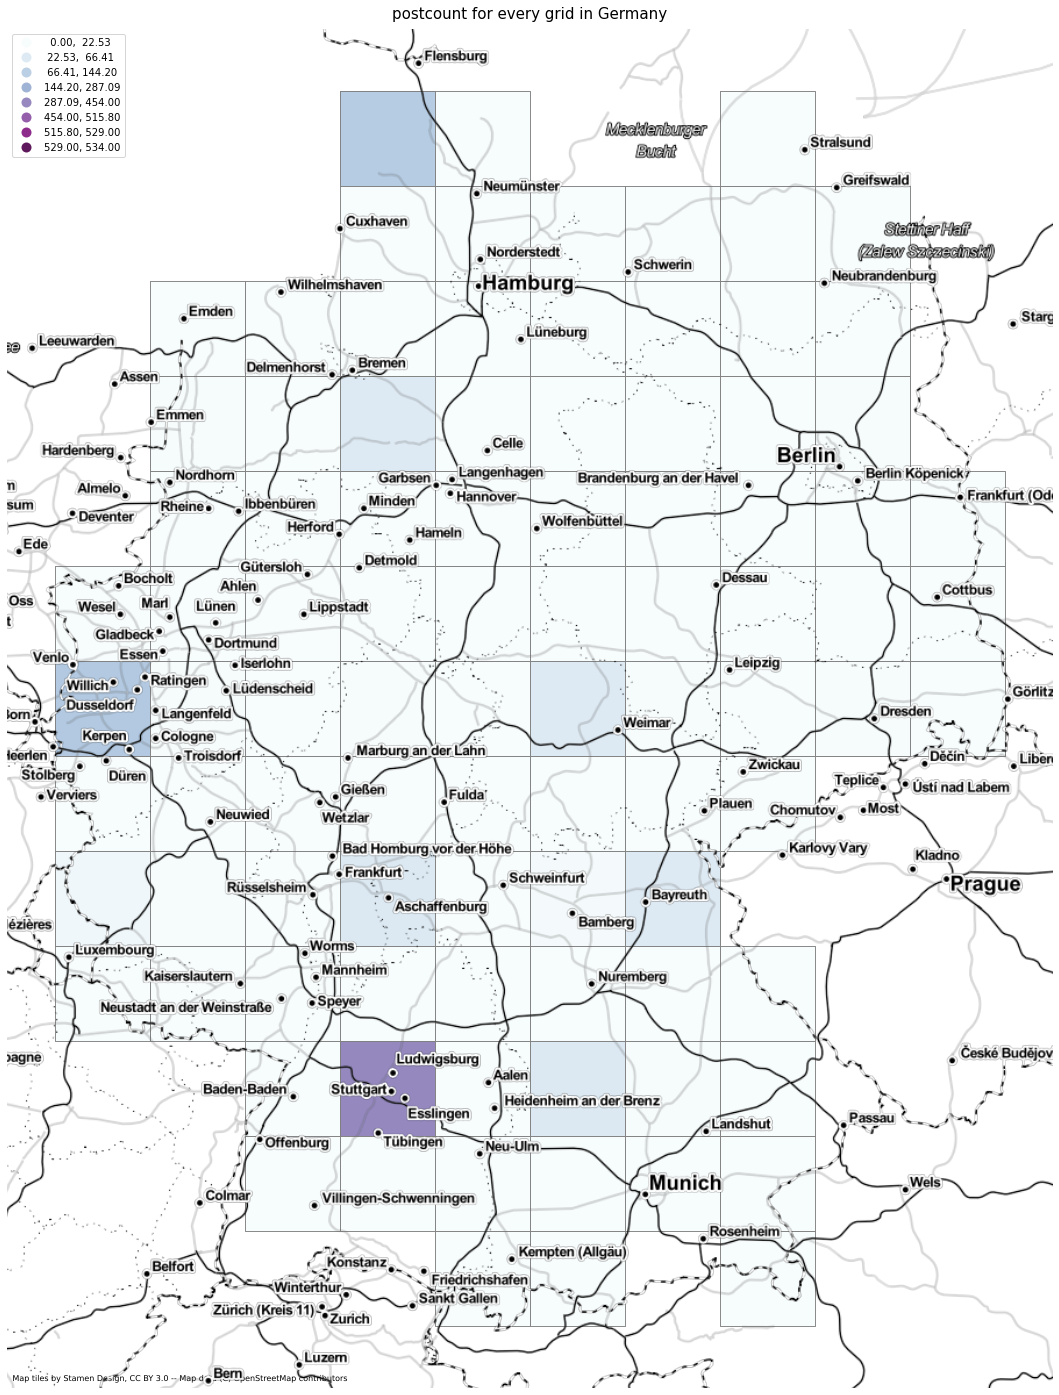

In [42]:
#now the final plot

ax = foo.plot(column = 'postcount', 
                  edgecolor = 'gray',
                  legend =True,
                  cmap = 'BuPu',                  
                  zorder = 5,
                  legend_kwds = {'loc':2},   
                  alpha = 0.9,
                  scheme = 'headtail_breaks',
                  figsize = (35,25)
                 )
ctx.add_basemap(ax, crs=foo.crs.to_string(), source=ctx.providers.Stamen.TonerHybrid)
plt.axis('off')
plt.title('postcount for every grid in Germany', size = '15', pad =10.0)

